# Gamma Ray Bursts

Here I do not have target labels, thus mine will be an unsupervised analysis.\
I am searching for a way to cluster my data based on the similarity of the features.\
First I will analyze the features and extract from them as much information as I can (summary statistics and hyperparameters)\
Then I will try yo cluster the data using more features at a time.

In [146]:
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Utilities\utils.py")
from Utilities import plot_settings
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from scipy.stats import norm

In [43]:
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.optimize import brentq

def find_intersection(x, y1, y2):
    """
    Find the intersection point of two lines defined by their y-intercepts and a point on each lin
    Parameters:
    x (float): The x-coordinate of the point where the two lines intersect
    y1 (float): The y-intercept of the first line
    y2 (float): The y-intercept of the second line
    Returns:
    float: The y-coordinate of the intersection point
    """
    
    diff_interp = interp1d(x, y1 - y2, kind='linear', fill_value="extrapolate")

    a, b = x[0], x[-1]
    if diff_interp(a) * diff_interp(b) >= 0:
        raise ValueError("No sign change in interval. Try narrowing the interval or checking data.")

    root = brentq(diff_interp, a, b)

    return root

In [44]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

C:\Users\ricca\AppData\Local\Temp\ipykernel_1848\3973052632.py:9: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [45]:
T90  = data[6]
T90_err = data[7]
F    = data[9]
Ferr = data[10]
R    = data[11] 

In [46]:
def mask(X):
    # Elimina righe che contengono la stringa '-999'
    mask_valid = ~np.any(X == '-999', axis=1)
    Y = X[mask_valid]

    # Converte in float
    Y = Y.astype(float)

    # Elimina righe che contengono zero
    mask_nonzero = ~np.any(Y == 0.0, axis=1)
    Y_clean = Y[mask_nonzero]

    return Y_clean, Y_clean.shape[0]

In [47]:
X = np.vstack([F, Ferr, T90, T90_err]).T
Y, size = mask(X)

I want to look at relative errors

Text(0, 0.5, 'Flux ')

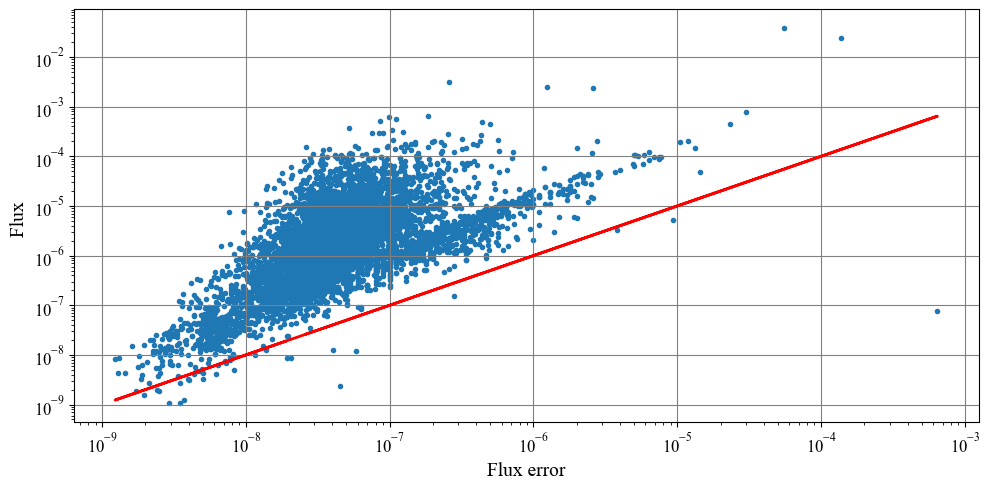

In [48]:
plt.scatter(Y.T[1], Y.T[0], marker='.')
plt.plot(Y.T[1], Y.T[1], lw=2, color='red')
plt.loglog()
plt.xlabel('Flux error')
plt.ylabel('Flux ')

Text(0, 0.5, 'T_90 ')

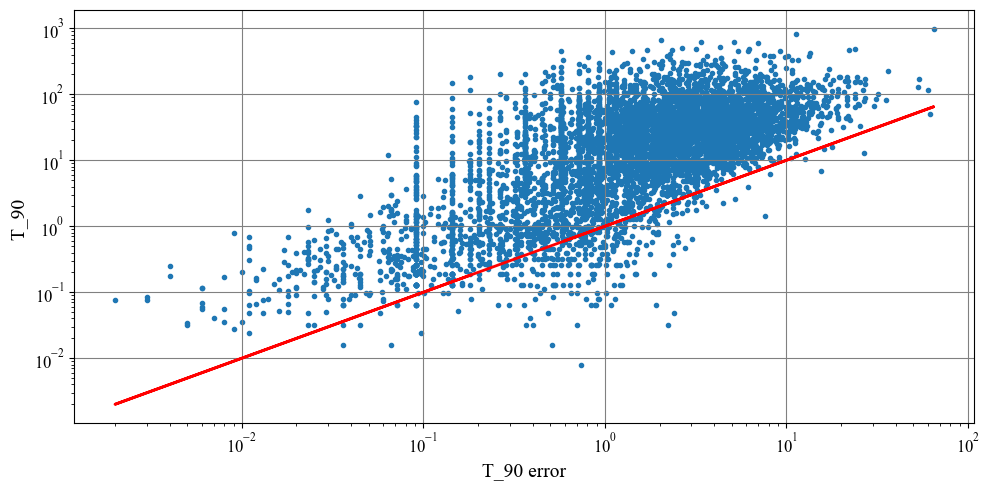

In [49]:
plt.scatter(Y.T[3], Y.T[2], marker='.')
plt.plot(Y.T[3], Y.T[3], lw=2, color='red')
plt.loglog()
plt.xlabel('T_90 error')
plt.ylabel('T_90 ')

All of the points appearing under the red line exhibit relative error bigger then 100%, thus they have to be discarded.\
I can also see a weird effect: there are points lying on lines parallel to the y axis with a $T_{90}$ value ranging from 0.1 to 100! This could be caused by the limited detector resolution. Or it could be that given a $T_{90}$ value, fluence (and thus counting statistic) can vary so much that the error attributed to GRBs with very different $T_{90}$ values could be the same.\
I'll look now into the 1D distributions of T90 and fluence.

In [ ]:
def mask2(X):
    mask_valid = ~np.any(X == '-999', axis=1)
    Y = X[mask_valid].astype(float)

    mask_nonzero = ~np.any(Y == 0.0, axis=1)
    Y = Y[mask_nonzero]

    F, Ferr, T90, T90_err = Y.T  
    mask_err_valid = (Ferr <= F) & (T90_err <= T90)

    Y_clean = Y[mask_err_valid]

    return Y_clean, Y_clean.shape[0]

In [51]:
X = np.vstack([F, Ferr, T90, T90_err]).T
Y, size = mask2(X)

Look at one particular feature...

Text(0, 0.5, 'Density')

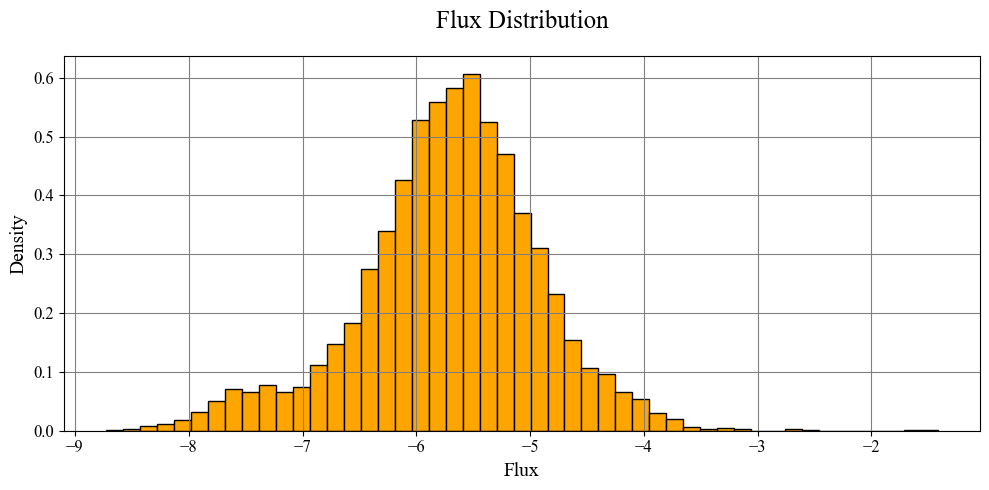

In [52]:
counts, bins,_ = plt.hist(np.log10(Y.T[0]), bins='scott', density=True, histtype='barstacked', color='orange', edgecolor='black')
plt.title('Flux Distribution')
plt.xlabel('Flux')
plt.ylabel('Density')

Seems like there are two gaussians hiding beneath this distribution...I'll use Gaussian Mixture

## Gaussian mixtures

Text(0.5, 1.0, 'Model selection: AIC and BIC')

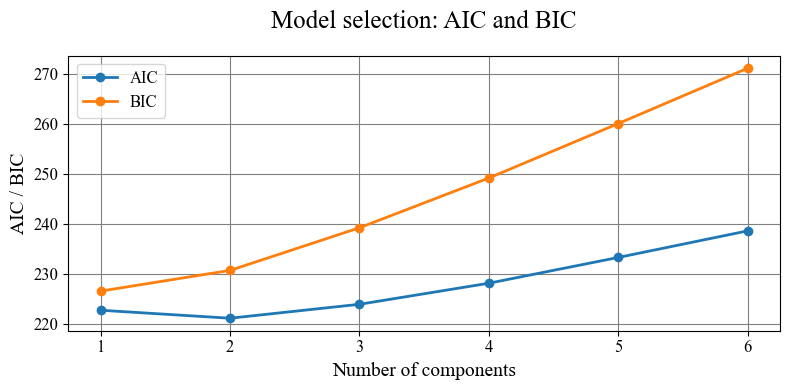

In [53]:
aic_values = []
bic_values = []
models = []
n_range = range(1, 7)  

for n in n_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(bins.reshape(-1,1))
    aic_values.append(gmm.aic(bins.reshape(-1,1)))
    bic_values.append(gmm.bic(bins.reshape(-1,1)))
    models.append(gmm)

plt.figure(figsize=(8,4))
plt.plot(n_range, aic_values, label='AIC', marker='o')
plt.plot(n_range, bic_values, label='BIC', marker='o')
plt.xlabel("Number of components")
plt.ylabel("AIC / BIC")
plt.legend()
plt.title("Model selection: AIC and BIC")

In [54]:
estimator = GaussianMixture(n_components=2)

In [55]:
estimator.fit(np.log10(Y.T[0]).reshape(-1,1))

GaussianMixture(n_components=2)

Text(0, 0.5, 'Density')

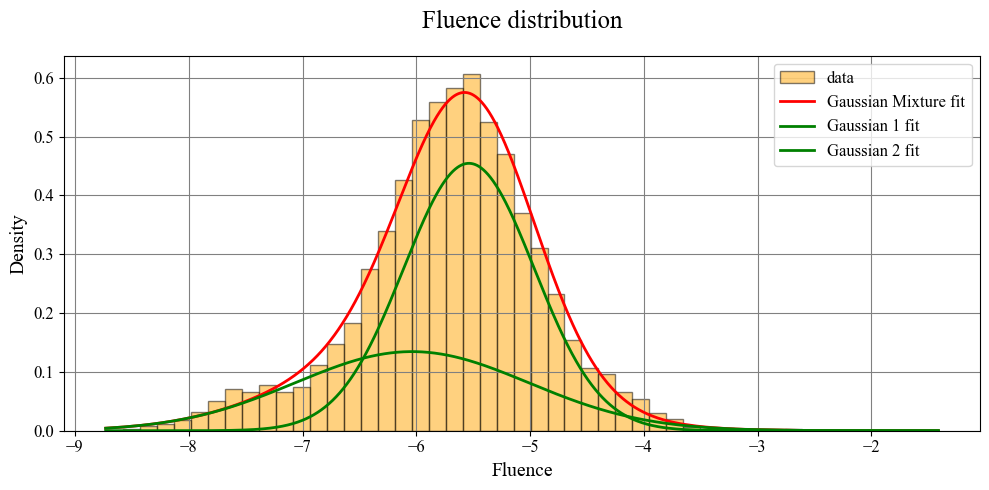

In [56]:
n1 = norm(loc=estimator.means_[0][0],scale=estimator.covariances_[0][0][0]**0.5) 
n2 = norm(loc=estimator.means_[1][0],scale=estimator.covariances_[1][0][0]**0.5) 
labels = estimator.predict(np.log10(Y.T[0]).reshape(-1,1))  

_,_,_ = plt.hist(np.log10(Y.T[0]), bins='scott', density=True, histtype='barstacked', color='orange', edgecolor='black', alpha=0.5, label='data')
x = np.sort(np.log10(Y.T[0]))
y = np.exp(estimator.score_samples(x.reshape(-1,1)))
plt.plot(x, y, lw=2, color='red', label='Gaussian Mixture fit')
plt.plot(x, n1.pdf(x)*estimator.weights_[0], lw=2, color='green', label='Gaussian 1 fit')
plt.plot(x, n2.pdf(x)*estimator.weights_[1], lw=2, color='green', label='Gaussian 2 fit')
plt.legend()
plt.title('Fluence distribution')
plt.xlabel('Fluence')
plt.ylabel('Density')

Text(0.5, 1.0, 'Means of gaussians $\\pm \\sigma$ ')

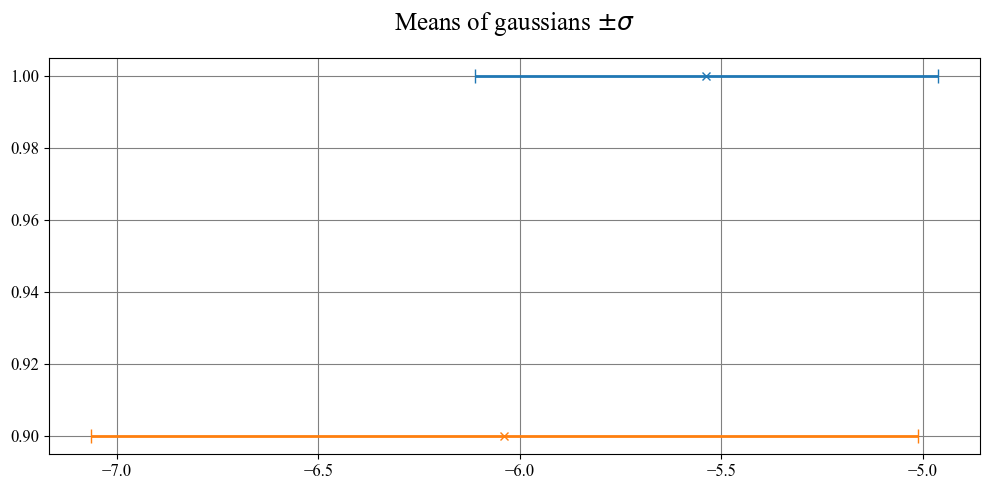

In [57]:
plt.errorbar(estimator.means_[0][0], 1, yerr=None, xerr=np.sqrt(estimator.covariances_[0][0][0]), fmt='x', barsabove=True, capsize=5, label='Estimator', alpha=1)
plt.errorbar(estimator.means_[1][0], 0.9, yerr=None, xerr=np.sqrt(estimator.covariances_[1][0][0]), fmt='x', barsabove=True, capsize=5, label='Estimator', alpha=1)
plt.title(r'Means of gaussians $\pm \sigma$ ')

It is evident that there is much overlap bewteen the modes

Text(0, 0.5, 'Density')

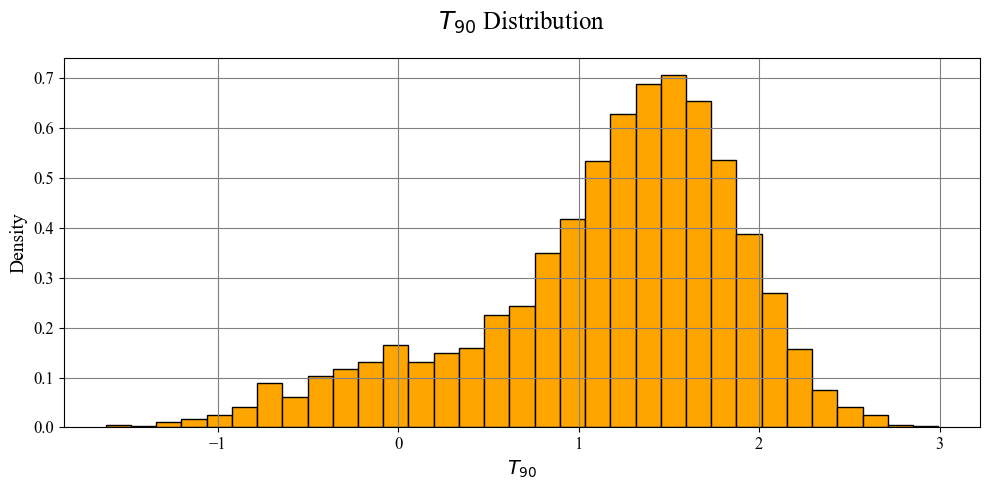

In [58]:
counts, bins, _ = plt.hist(np.log10(Y.T[2]), bins='scott', density=True, histtype='barstacked', color='orange', edgecolor='black')
plt.title(r'$T_{90}$ Distribution')
plt.xlabel(r'$T_{90}$')
plt.ylabel('Density')

Text(0.5, 1.0, 'Model selection: AIC and BIC')

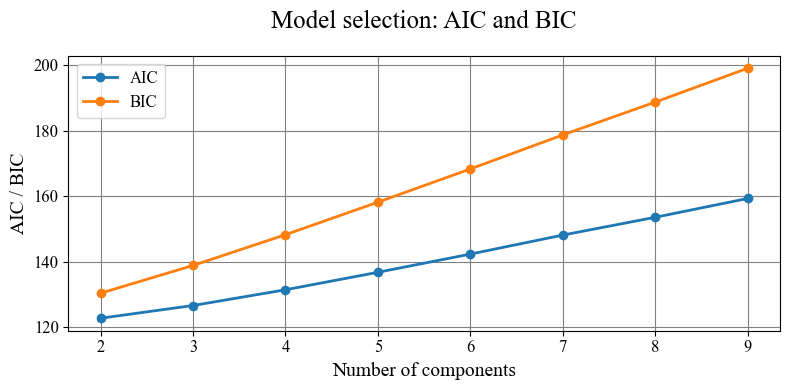

In [59]:
aic_values = []
bic_values = []
models = []
n_range = range(2, 10)  

for n in n_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(bins.reshape(-1,1))
    aic_values.append(gmm.aic(bins.reshape(-1,1)))
    bic_values.append(gmm.bic(bins.reshape(-1,1)))
    models.append(gmm)

plt.figure(figsize=(8,4))
plt.plot(n_range, aic_values, label='AIC', marker='o')
plt.plot(n_range, bic_values, label='BIC', marker='o')
plt.xlabel("Number of components")
plt.ylabel("AIC / BIC")
plt.legend()
plt.title("Model selection: AIC and BIC")

In [178]:
estimator = GaussianMixture(n_components=2)
estimator.fit(np.log10(Y.T[2]).reshape(-1,1))

GaussianMixture(n_components=2)

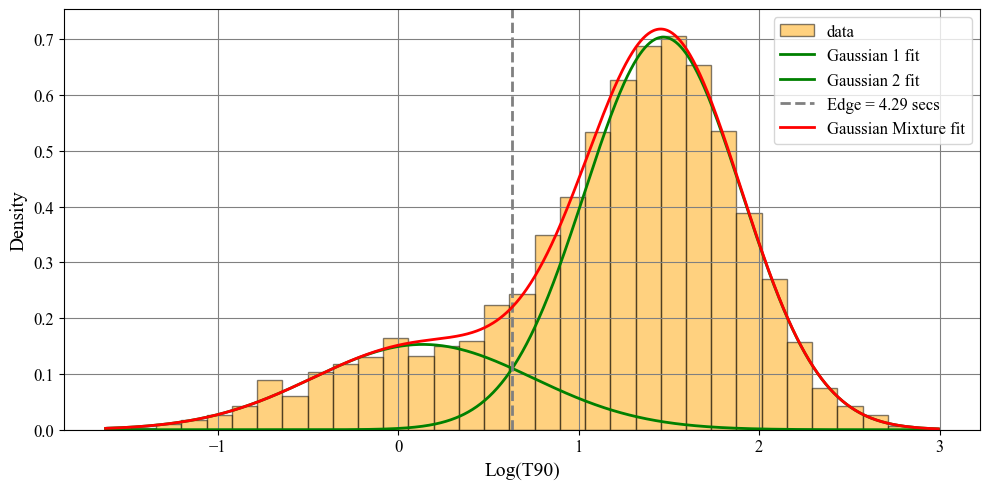

In [188]:
n1 = norm(loc=estimator.means_[0][0],scale=estimator.covariances_[0][0][0]**0.5)
n2 = norm(loc=estimator.means_[1][0],scale=estimator.covariances_[1][0][0]**0.5)

_,_,_ = plt.hist(np.log10(Y.T[2]), bins='scott', density=True, histtype='barstacked', color='orange', edgecolor='black', alpha=0.5, label='data')
x = np.linspace(min(np.log10(Y.T[2])),max((np.log10(Y.T[2]))),1000)
y = np.exp(estimator.score_samples(x.reshape(-1,1)))
plt.plot(x, n1.pdf(x)*estimator.weights_[0], lw=2, color='green', label='Gaussian 1 fit')
plt.plot(x, n2.pdf(x)*estimator.weights_[1], lw=2, color='green', label='Gaussian 2 fit')
edge_gm = find_intersection(x,n1.pdf(x)*estimator.weights_[0],n2.pdf(x)*estimator.weights_[1])
plt.axvline(edge_gm, 0, 1, linestyle='--', color='grey', lw=2 , label=f'Edge = {10**edge_gm:.3} secs')
plt.plot(x, y, lw=2, color='red', label='Gaussian Mixture fit')
plt.ylabel('Density')
plt.xlabel('Log(T90)')
plt.legend()

Text(0.5, 1.0, 'Means of gaussians $\\pm \\sigma$ ')

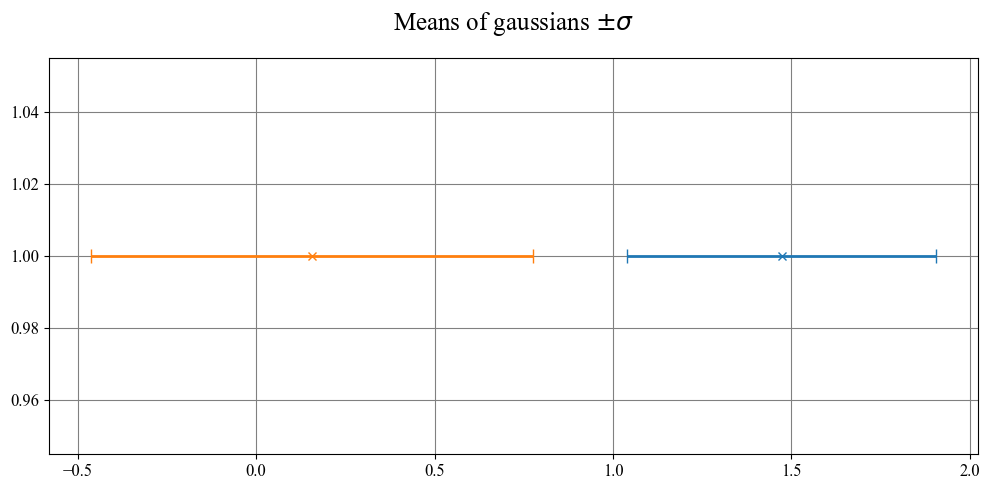

In [62]:
plt.errorbar(estimator.means_[0][0], 1, yerr=None, xerr=np.sqrt(estimator.covariances_[0][0][0]), fmt='x', barsabove=True, capsize=5, label='Estimator')
plt.errorbar(estimator.means_[1][0], 1, yerr=None, xerr=np.sqrt(estimator.covariances_[1][0][0]), fmt='x', barsabove=True, capsize=5, label='Estimator')
plt.title(r'Means of gaussians $\pm \sigma$ ')

In [63]:
labels = estimator.predict(np.log10(Y.T[2]).reshape(-1,1))

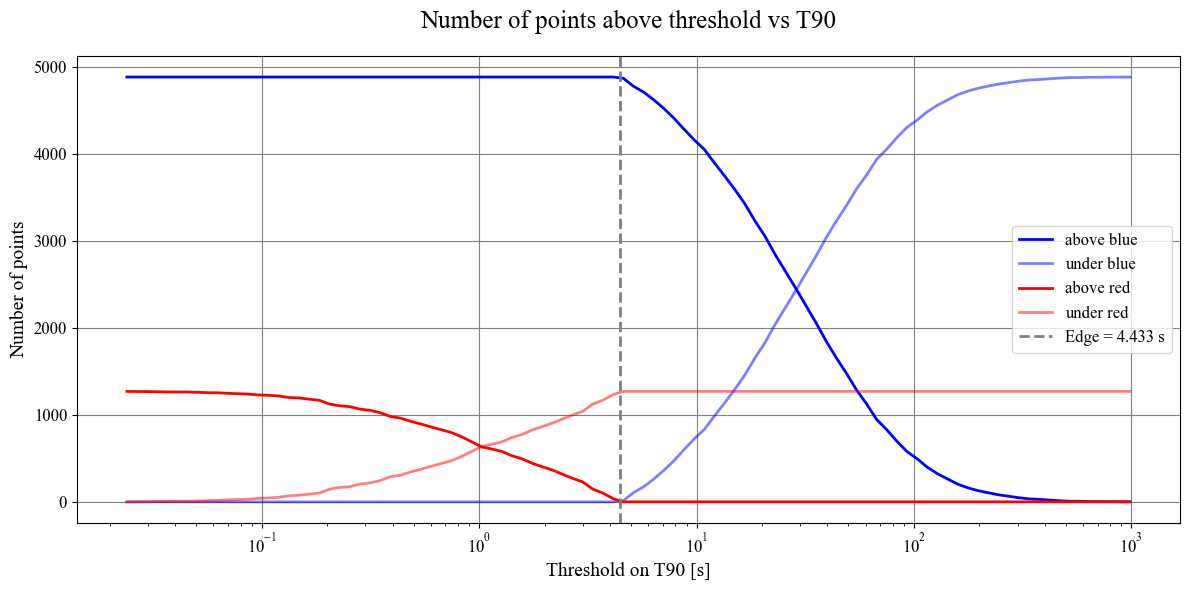

In [64]:
# Filtra i valori non validi
T90 = Y.T[2]
valid_mask = T90 > 0
T90 = T90[valid_mask]
labels = labels[valid_mask]

# Trasformazione log10
logT90 = np.log10(T90)

# Soglie in spazio logaritmico
thresholds = np.linspace(np.min(logT90), np.max(logT90), 100)

counts = {
    'below': {'red': [], 'blue': []},
    'above': {'red': [], 'blue': []}
}

for thresh in thresholds:
    mask_below = logT90 < thresh
    mask_above = logT90 >= thresh

    counts['below']['red'].append(np.sum((labels == 1) & mask_below))
    counts['below']['blue'].append(np.sum((labels == 0) & mask_below))
    counts['above']['red'].append(np.sum((labels == 1) & mask_above))
    counts['above']['blue'].append(np.sum((labels == 0) & mask_above))

# Converti in array
for side in ['below', 'above']:
    for color in ['red', 'blue']:
        counts[side][color] = np.array(counts[side][color])

# Totali
total_red = np.sum(labels == 1)
total_blue = np.sum(labels == 0)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(10**thresholds, counts['above']['blue'], label='above blue', color='blue', alpha=1)
plt.plot(10**thresholds, counts['below']['blue'], label='under blue', color='blue', alpha=0.5)
plt.plot(10**thresholds, counts['above']['red'], label='above red', color='red', alpha=1)
plt.plot(10**thresholds, counts['below']['red'], label='under red', color='red', alpha=0.5)

# Edge (intersezione delle gaussiane, se esiste)
plt.axvline(10**root, color='gray', linestyle='--', lw=2, label=f'Edge = {10**root:.3f} s')

plt.xscale('log')
plt.xlabel('Threshold on T90 [s]')
plt.ylabel('Number of points')
plt.title('Number of points above threshold vs T90')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**What's the threshold between the classes?**\
$T_{90}$ edge is at $4.433$ seconds

In [65]:
A = np.vstack([np.log10(Y.T[0]),np.log10(Y.T[2])]).T

In [ ]:
A_train, A_test = train_test_split(A, test_size=0.2)

In [66]:
gm = GaussianMixture(2, random_state=42)
gm.fit(A)
labels = gm.predict(A)

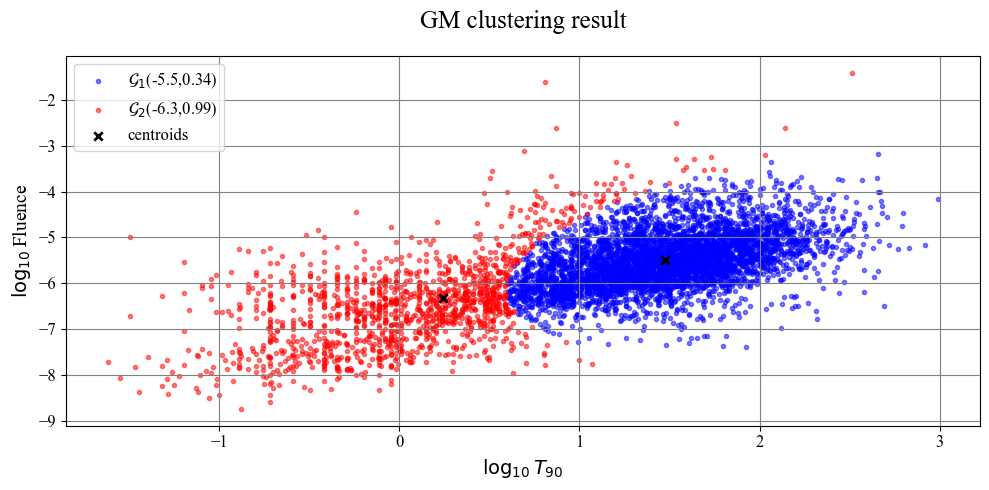

In [67]:
plt.scatter(A.T[1][labels==0],A.T[0][labels==0],marker='.', color='blue', label=r"$\mathcal{G}_1$"+f'({gm.means_[0][0]:.2},{gm.covariances_[0][0][0]:.2})', alpha=0.5)
plt.scatter(A.T[1][labels==1],A.T[0][labels==1],marker='.', color='red',  label=r"$\mathcal{G}_2$"+f'({gm.means_[1][0]:.2},{gm.covariances_[1][0][0]:.2})', alpha=0.5)
plt.scatter(gm.means_[:,1],gm.means_[:,0], marker='x', color='black', label='centroids')
plt.xlabel(r'$\log_{10}T_{90}$')
plt.ylabel(r'$\log_{10}$Fluence')
plt.title('GM clustering result')
plt.legend()

In [68]:
print(f'Cluster 1:  G({10**gm.means_[0]}, {np.diag(gm.covariances_[0])})')
print(f'Cluster 2:  G({10**gm.means_[1]}, {np.diag(gm.covariances_[1])})')

Cluster 1:  G([3.15913949e-06 2.97598919e+01], [0.34332935 0.18927536])
Cluster 2:  G([4.78989324e-07 1.73673849e+00], [0.98555907 0.4623903 ])


**Does the distribution contain different sub-populations? How many?**\
Using GM I found two sub distributions:
 1. Short GRBs with a mean time of $1.73 s$ and a mean fluence of $3.16\times10^{-6} \frac{\text{erg}}{\text{cm}^2}$
 2. Long GRBs with a mean time of $29.73 s$ and a mean fluence of $4.78\times10^{-7} \frac{\text{erg}}{\text{cm}^2}$
 
Thus short GRBs are more frequent then longer ones.

## Mean-Shift

In [133]:
ms = MeanShift(bandwidth = 1)

In [139]:
labels = ms.fit_predict(A)

In [140]:
import matplotlib
a = matplotlib.color_sequences['Set1']

Text(0.5, 1.0, 'Mean-Shift clustering result')

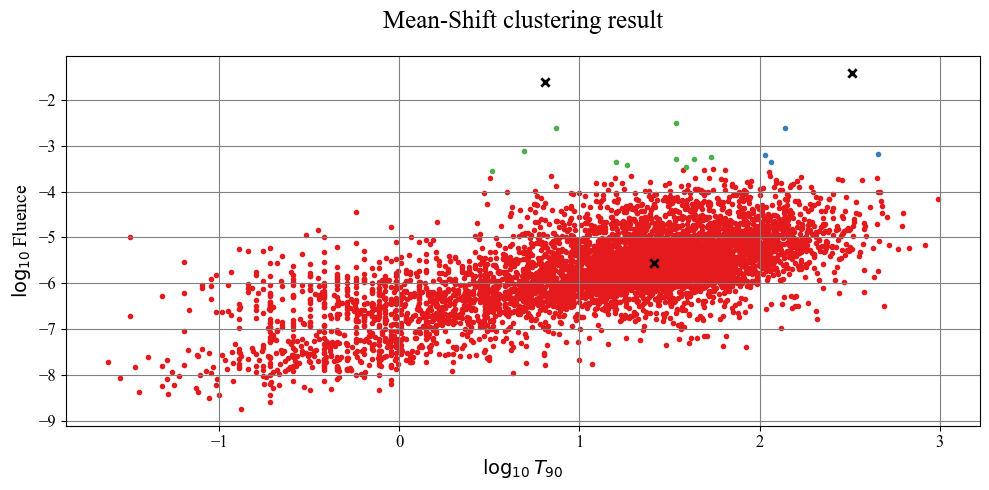

In [142]:
for i in range(len(ms.cluster_centers_)):
    plt.scatter(A.T[1][labels==i], A.T[0][labels==i], marker='.', color=a[i])
plt.scatter(ms.cluster_centers_[:,1], ms.cluster_centers_[:,0], marker='x', color='black')
plt.xlabel(r'$\log_{10}T_{90}$')
plt.ylabel(r'$\log_{10}$Fluence')
plt.title('Mean-Shift clustering result')

It is apparent that this method is very sensible to outliers.

## K-Means

$T_{90}$

In [173]:
km = KMeans(n_clusters=2, random_state=42)

In [174]:
labels = km.fit_predict(np.log10(Y.T[2]).reshape(-1,1))

In [175]:
edge_km = 10**np.mean([np.sort(np.log10(Y.T[2])[labels==0]).min(),np.sort(np.log10(Y.T[2])[labels==1]).max()])
print(f'Edge = {edge_km:.3} seconds')

Edge = 6.63 seconds


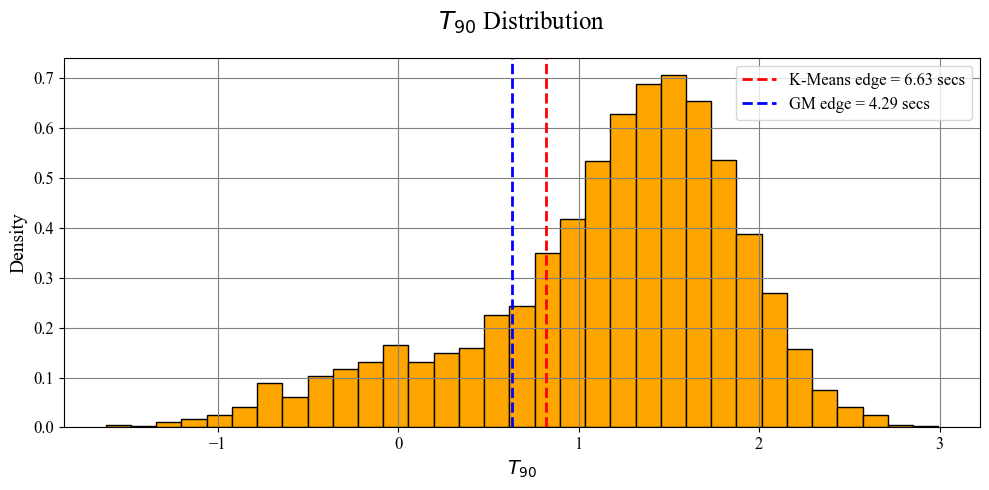

In [189]:
counts, bins, _ = plt.hist(np.log10(Y.T[2]), bins='scott', density=True, histtype='barstacked', color='orange', edgecolor='black')
plt.axvline(np.log10(edge_km),0,1,linestyle='--', color='red', lw=2, label=f'K-Means edge = {edge_km:.3} secs')
plt.axvline(edge_gm,0,1,linestyle='--', color='blue', lw=2., label=f'GM edge = {10**edge_gm:.3} secs')
plt.title(r'$T_{90}$ Distribution')
plt.xlabel(r'$T_{90}$')
plt.ylabel('Density')
plt.legend()

2D

Text(0.5, 1.0, 'Silhouette Analysis')

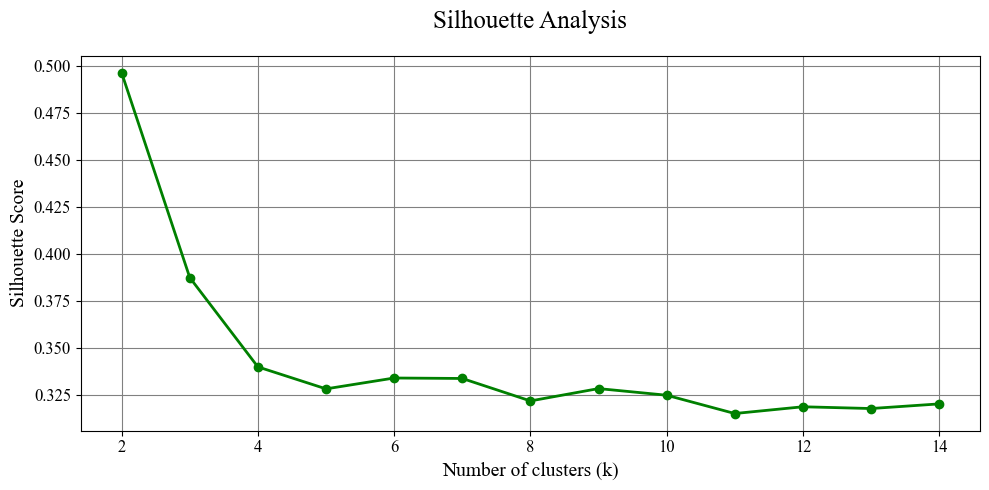

In [145]:
from sklearn.metrics import silhouette_score

sil_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(A)
    score = silhouette_score(A, kmeans.labels_)
    sil_scores.append(score)

plt.plot(range(2, 15), sil_scores, 'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

In [149]:
km = KMeans(n_clusters=2, random_state=42)
labels = km.fit_predict(A)

In [150]:
import matplotlib
a = matplotlib.color_sequences['Set1']

Text(0.5, 1.0, 'KMeans clustering result')

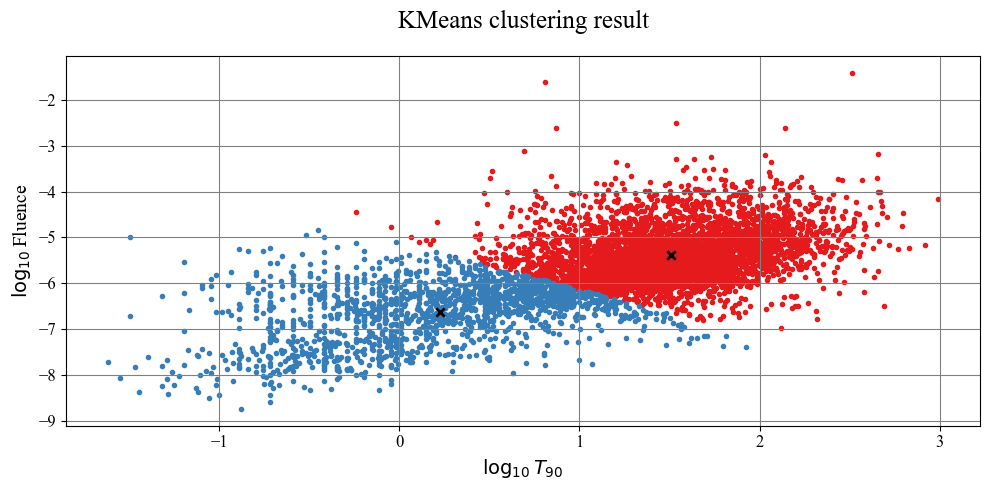

In [151]:
for i in range(km.n_clusters):
    plt.scatter(A.T[1][labels==i], A.T[0][labels==i], marker='.', color=a[i])
plt.scatter(km.cluster_centers_[:,1], km.cluster_centers_[:,0], marker='x', color='black')
plt.xlabel(r'$\log_{10}T_{90}$')
plt.ylabel(r'$\log_{10}$Fluence')
plt.title('KMeans clustering result')

It is evident that this particular clustering method is not influenced much by outliers

In [90]:
for i,a in enumerate(['Fluence', 'T90']):
    print(a)
    for l,c,m in zip(['Short GRBs','Long GRBs'],np.sort(km.cluster_centers_[:,i]),np.sort(gm.means_[:,i])):
        print(l,": ", c,m, np.abs(c-m)/np.mean([c,m]) )
        

Fluence
Short GRBs :  -7.477535640176366 -6.319674166049721 -0.16783994595837082
Long GRBs :  -6.326331940158505 -5.500431198201294 -0.13966640445827877
T90
Short GRBs :  -0.32710399766311915 0.23973442971132253 -12.975649088414325
Long GRBs :  0.09614045358891943 1.473631349900258 1.755020561905303
